In [1]:
pip install torch torchvision torchaudio transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

In [14]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [15]:
from transformers import BertModel, BertTokenizer

In [16]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output

In [17]:
class AudioEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [18]:
class MultimodalClassifier(nn.Module):
    def __init__(self, img_dim=2048, txt_dim=768, aud_dim=16, num_classes=3):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.audio_encoder = AudioEncoder()
        self.classifier = nn.Sequential(
            nn.Linear(img_dim + txt_dim + aud_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask, audio):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        aud_feat = self.audio_encoder(audio)
        combined = torch.cat((img_feat, txt_feat, aud_feat), dim=1)
        return self.classifier(combined)

In [19]:
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, num_samples=100):
        self.tokenizer = tokenizer
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)
        audio = torch.randn(1, 16000)
        text = "This is a sample input text"
        tokens = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=32)
        return (
            image,
            tokens["input_ids"].squeeze(0),
            tokens["attention_mask"].squeeze(0),
            audio,
            torch.tensor(idx % 3)  # Labels: 0,1,2
        )

In [20]:
def train_and_evaluate():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = DummyDataset(tokenizer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

    model = MultimodalClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()

    epochs = 3
    for epoch in range(epochs):
        total_loss = 0
        for image, input_ids, attention_mask, audio, labels in dataloader:
            outputs = model(image, input_ids, attention_mask, audio)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3, Loss: 14.3803
Epoch 2/3, Loss: 14.4979
Epoch 3/3, Loss: 14.3230

📊 Evaluation Metrics:
✔️ Accuracy: 0.38
📈 Precision: 0.36
📉 Recall: 0.38
📊 F1 Score: 0.34


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


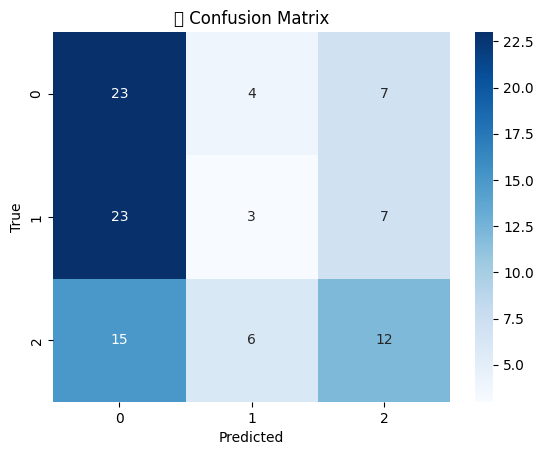

In [25]:
def train_and_evaluate():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = DummyDataset(tokenizer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

    model = MultimodalClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    model.train()

    epochs = 3
    for epoch in range(epochs):
        total_loss = 0
        for image, input_ids, attention_mask, audio, labels in dataloader:
            outputs = model(image, input_ids, attention_mask, audio)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    # ✅ 7. Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for image, input_ids, attention_mask, audio, labels in dataloader:
            outputs = model(image, input_ids, attention_mask, audio)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print("\n📊 Evaluation Metrics:")
    print(f"✔️ Accuracy: {acc:.2f}")
    print(f"📈 Precision: {precision:.2f}")
    print(f"📉 Recall: {recall:.2f}")
    print(f"📊 F1 Score: {f1:.2f}")

    # ✅ 8. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("🔁 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ✅ Run everything
train_and_evaluate()